In [796]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from scipy.stats import norm
import tqdm as tqdm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statistics import mode

In [797]:
#Please select product type:
#To select the Installment Loan - input 1
#To select the Revolving Credit Line - input 2
#To select the Deposit - input 3
#To select the Savings Account - input 4
product = 1

#Please select the product maturity in months (1-35):
maturity = 30

In [798]:
#Credit Spread Calc:

#Please select the borrower's Credit Rating (A, B, or C):
CR = 'B'
if CR == 'A':
    PD = 0.05
elif CR == 'B':
    PD = 0.1
else:
    PD = 0.2

#Please select the collateral coverage percent (as a decimal):
collateralpct = 0.75
LGD = 1-collateralpct

CS = PD*LGD
print(f'The Pre-Simulation Credit Spread for this Client is {CS*100} %')

The Pre-Simulation Credit Spread for this Client is 2.5 %


In [799]:
#Bank Profit Settings:

OC = 0.005 #Operating Costs in pct (as a decimal)
#Please input the desired Asset Interest Margin (as a decimal):
IM = 0.05

In [800]:
#Yield Curve Settings: (manual input for this model)
yield_curve_name = 'MOEX Zero Coupon Yield Curve'
data_input_date = '19.03.2025'
m1 = 0.2338
m2 = 0.2253
m3 = 0.2168
m4 = 0.2101
m5 = 0.2041
m6 = 0.1980
m7 = 0.1931
m8 = 0.1887
m9 = 0.1843
m10 = 0.1808
m11 = 0.1776
m12 = 0.1744
m13 = 0.1718
m14 = 0.1695
m15 = 0.1672
m16 = 0.1653
m17 = 0.1636
m18 = 0.1619
m19 = 0.1605
m20 = 0.1593
m21 = 0.1580
m22 = 0.1570
m23 = 0.1561
m24 = 0.1552
maturities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yields = [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14, m15, m16, m17, m18, m19, m20, m21, m22, m23, m24]

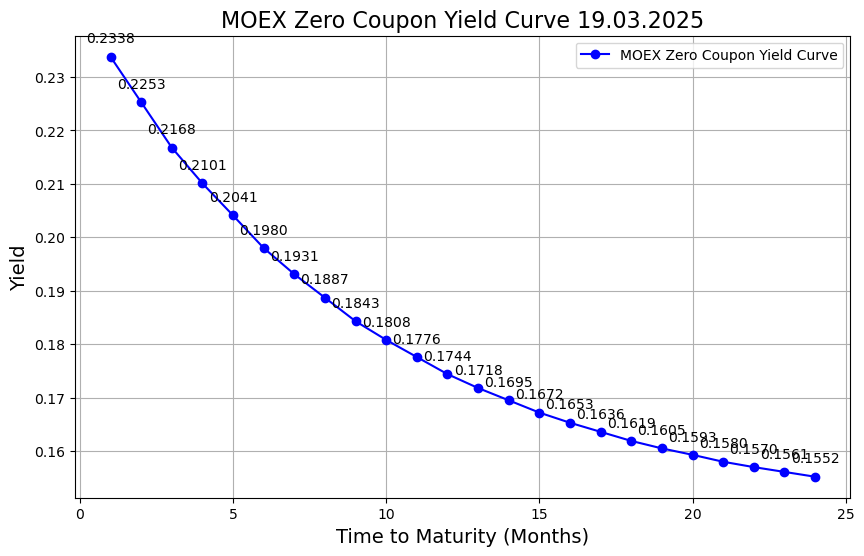

In [801]:
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields, marker='o', linestyle='-', color='b', label=yield_curve_name)
plt.title(f'{yield_curve_name} {data_input_date}', fontsize=16)
plt.xlabel('Time to Maturity (Months)', fontsize=14)
plt.ylabel('Yield', fontsize=14)
plt.grid(True)
for i, (x, y) in enumerate(zip(maturities, yields)):
    plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()
plt.show()

In [802]:
#ADF test to test the time series for stationarity
result = adfuller(yields, autolag='AIC')  # Use AIC to automatically select the lag length
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value:.4f}")
if p_value < 0.05:
    print("The time series is stationary (reject the null hypothesis).")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis).")
if p_value >= 0.05:
    print("\nApplying differencing to make the time series stationary...")
    yields = pd.Series(yields)
    yields_diff = yields.diff().dropna()
    
    result_diff = adfuller(yields_diff, autolag='AIC')
    adf_statistic_diff = result_diff[0]
    p_value_diff = result_diff[1]
    critical_values_diff = result_diff[4]

    print("\nResults for Differenced Data:")
    print(f"ADF Statistic: {adf_statistic_diff:.4f}")
    print(f"p-value: {p_value_diff:.4f}")
    print("Critical Values:")
    for key, value in critical_values_diff.items():
        print(f"   {key}: {value:.4f}")
    if p_value_diff < 0.05:
        print("The differenced time series is stationary (reject the null hypothesis).")
    else:
        print("The differenced time series is still non-stationary (fail to reject the null hypothesis).")
else:
    print("\nNo differencing needed. The time series is already stationary.")

ADF Statistic: -1.7599
p-value: 0.4006
Critical Values:
   1%: -3.9240
   5%: -3.0685
   10%: -2.6739
The time series is non-stationary (fail to reject the null hypothesis).

Applying differencing to make the time series stationary...

Results for Differenced Data:
ADF Statistic: -6.3478
p-value: 0.0000
Critical Values:
   1%: -3.8893
   5%: -3.0544
   10%: -2.6670
The differenced time series is stationary (reject the null hypothesis).


In [803]:
maturities = maturities[:-1]

In [804]:
#OLS for alpha and theta calculations
x = maturities
y = yields_diff
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
y_pred = results.predict(X)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     185.5
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           6.83e-12
Time:                        22:07:43   Log-Likelihood:                 133.16
No. Observations:                  23   AIC:                            -262.3
Df Residuals:                      21   BIC:                            -260.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0074      0.000    -22.154      0.0

In [805]:
t = 1
b0 = results.params[0]
b1 = results.params[1]
alpha = -b1/t
theta = (-b0/b1)/100 #Did /100 to convert whole number to a decimal (22%)
print(f"Alpha: {alpha:.4f}")
print(f"Theta: {theta:.4f}")

Alpha: -0.0003
Theta: 0.2231


/var/folders/68/wtl2nd4s0j3fvb1d1nt0qxvh0000gn/T/ipykernel_61395/118164658.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b0 = results.params[0]
/var/folders/68/wtl2nd4s0j3fvb1d1nt0qxvh0000gn/T/ipykernel_61395/118164658.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b1 = results.params[1]


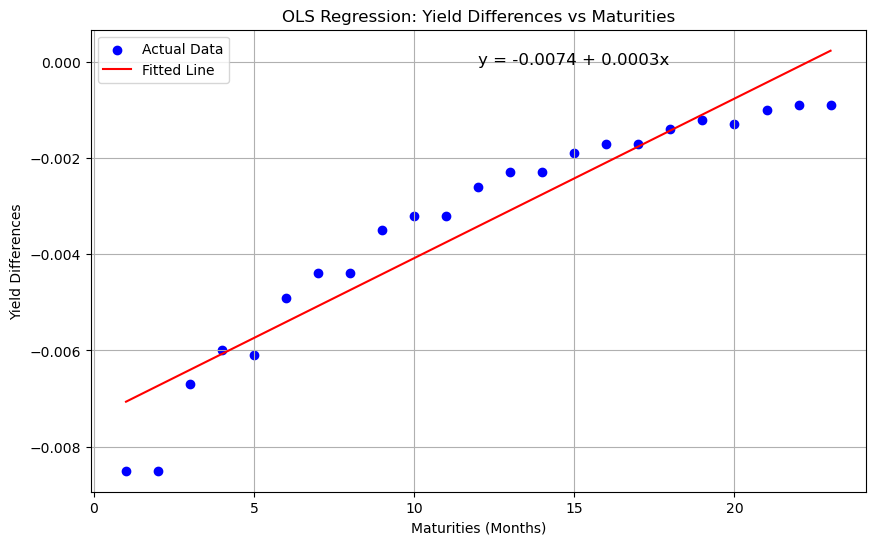

In [806]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Actual Data')
plt.plot(x, y_pred, color='red', label='Fitted Line')
equation = f'y = {b0:.4f} + {b1:.4f}x'
plt.text(0.5, 0.95, equation, fontsize=12, transform=plt.gca().transAxes, verticalalignment='top')
plt.title('OLS Regression: Yield Differences vs Maturities')
plt.xlabel('Maturities (Months)')
plt.ylabel('Yield Differences')
plt.legend()
plt.grid(True)
plt.show()


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 6252.09it/s]


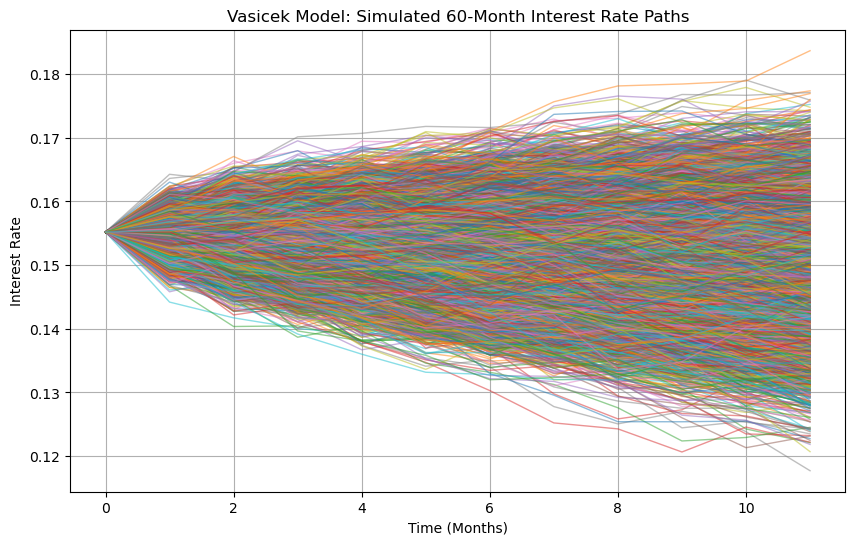

In [807]:
#The Vasicek Model for Interest Rate Simualtion
alpha = b0
theta = theta
sigma = pd.Series(yields)
sigma = sigma-sigma.shift(1)
sigma = sigma.std()          #Calculating Standard Deviation of Changes in Yield

r0 = m24 #Month 1 of Simulation

# Simulation parameters
T = 12  # 60 months (5 years)
dt = 1  # Time step (1 month)
n_simulations = 10000 #Number of simulations


def vasicek_simulate(r0, alpha, theta, sigma, T, dt, n_simulations):
    n_steps = int(T / dt)
    rates = np.zeros((n_simulations, n_steps))
    rates[:, 0] = r0

    for t in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), n_simulations)
        dr = alpha * (theta - rates[:, t - 1]) * dt + sigma * dW
        rates[:, t] = rates[:, t - 1] + dr

    return rates
simulated_rates = vasicek_simulate(r0, alpha, theta, sigma, T, dt, n_simulations)
plt.figure(figsize=(10, 6))
for i in tqdm.tqdm(range(n_simulations)):
    plt.plot(simulated_rates[i], lw=1, alpha=0.5)
plt.title("Vasicek Model: Simulated 60-Month Interest Rate Paths")
plt.xlabel("Time (Months)")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()

In [808]:
#Create a new dataframe from given and simulated yields
mean_simulated_rates = np.mean(simulated_rates, axis=0)
old_yields_df = pd.DataFrame({
    "Month": np.arange(1, 25), 
    "Yield": yields  
})

simulated_rates_df = pd.DataFrame({
    "Month": np.arange(25, 25 + T), 
    "Yield": mean_simulated_rates  
})
combined_df = pd.concat([old_yields_df, simulated_rates_df], ignore_index=True)
print(combined_df)

    Month     Yield
0       1  0.233800
1       2  0.225300
2       3  0.216800
3       4  0.210100
4       5  0.204100
5       6  0.198000
6       7  0.193100
7       8  0.188700
8       9  0.184300
9      10  0.180800
10     11  0.177600
11     12  0.174400
12     13  0.171800
13     14  0.169500
14     15  0.167200
15     16  0.165300
16     17  0.163600
17     18  0.161900
18     19  0.160500
19     20  0.159300
20     21  0.158000
21     22  0.157000
22     23  0.156100
23     24  0.155200
24     25  0.155200
25     26  0.154707
26     27  0.154199
27     28  0.153683
28     29  0.153170
29     30  0.152641
30     31  0.152072
31     32  0.151554
32     33  0.151041
33     34  0.150502
34     35  0.149973
35     36  0.149381


In [809]:
yield_month = combined_df[combined_df["Month"] == maturity]["Yield"].values[0]
yield_month

0.15264126605091402

In [810]:
#Borrower Credit Rating Migration Simulation

def mccr(migration_matrix, num_months, num_simulations, initial_rating):
    ratings = list(migration_matrix.keys())
    transition_matrix = np.array([migration_matrix[rating] for rating in ratings])
    initial_index = ratings.index(initial_rating)
    results = []


    for _ in tqdm.tqdm(range(num_simulations)):
        current_rating_index = initial_index
        simulation_path = [ratings[current_rating_index]]

        for _ in range(num_months):
            transition_probs = transition_matrix[current_rating_index]

            next_rating_index = np.random.choice(len(ratings), p=transition_probs)
            simulation_path.append(ratings[next_rating_index])

            current_rating_index = next_rating_index

        results.append(simulation_path)

    return results


# Example usage
migration_matrix = {
    "A": [0.85, 0.10, 0.05], #1. Stays A. 2. Migration to B. 3. Migration to C
    "B": [0.10, 0.80, 0.10], #1. Migration to A. 2. Stays B. 3. Migration to C
    "C": [0.05, 0.15, 0.80]  #1. Migration to A. 2. Migration to B. 3. Stays C
}

num_months = maturity
num_simulations = 10000
initial_rating = 'B'

results = mccr(migration_matrix, num_months, num_simulations, initial_rating)
last_column = [simulation[-1] for simulation in results]
CRS = mode(last_column)
if CRS == 'A':
    PD1 = 0.05
elif CRS == 'B':
    PD1 = 0.1
else:
    PD1 = 0.2

CSS = PD1*LGD

print(f"The Simulated Credit Rating in {maturity} months is: {CRS}")
print(f'The Simulated Credit Spread for this Client is {CSS*100} %')


100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4444.15it/s]

The Simulated Credit Rating in 30 months is: B
The Simulated Credit Spread for this Client is 2.5 %


In [811]:
#Optionality Interest Spread Calc:
def black_scholes_put(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return put_price
S0 = 100000  # Current account balance - hypothetical, used for scaling
K = 100000   # Strike price - also hypothetical, has to be same as S0
T = maturity/12       # Time to maturity (in years)
r = yield_month    # Product maturity rate
if product == 2: # Volatility of the account balance / client activity (as a decimal)
    sigma = 0.15
else: sigma = 0.25
put_price = black_scholes_put(S0, K, T, r, sigma)
OS = (put_price / S0)
OS1 = (put_price / S0) * 100
print(f"Optionality Interest Spread (APR): {OS1:.2f}%")

Optionality Interest Spread (APR): 2.87%


In [812]:
#Liquidity Premium Calc
if maturity < 12:
    LP = 0
elif 12 < maturity < 24:
    LP = 0.005
else: LP = 0.009
print(f'The Liquidity Premium for this Loan is {LP*100:.2f} %')

The Liquidity Premium for this Loan is 0.90 %


In [813]:
#Final Product Calculations:
if product == 1:
    rate = yield_month+CSS+IM+OC+LP
    print(f'The APR on the Installment Loan is {rate*100:.2f} %')
elif product == 2:
    rate = yield_month+CSS+IM+OS+OC+LP
    print(f'The APR on the Revolving Credit Line is {rate*100:.2f} %')
elif product == 3:
    rate = yield_month+IM-OC+LP
    print(f'The APR on the Deposit is {rate*100:.2f} %')
else: 
    rate = yield_month+IM-OS-OC+LP
    print(f'The APR on the Savings Account is {rate*100:.2f} %')

The APR on the Installment Loan is 24.16 %
